In [1]:
from image_dataset import ImageDataset
import torch
from torch import nn
from refiners.fluxion import layers as fl
from refiners.fluxion.adapters.adapter import Adapter
from refiners.fluxion import utils
import PIL
import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
parallel_layer = fl.Parallel(
    fl.Linear(32, 8),
    fl.Linear(32, 8),
)
class NormalRepametrization(fl.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        mu, logvar = input
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z

second_parallel_layer = fl.Parallel(
    NormalRepametrization(),
    fl.Identity(),
)
tensor = torch.randn(10,32)
outputs = parallel_layer(tensor)
print(outputs[0].shape)
print(outputs[1].shape)
outputs_2 = second_parallel_layer(outputs)


# assert len(outputs) == 3
# assert outputs[0].shape == (2, 64)
# assert torch.allclose(outputs[1], tensor)
# assert outputs[2].shape == (2, 128)

torch.Size([10, 8])
torch.Size([10, 8])


In [28]:

# Resblock
class Resblock(fl.Sum):
    def __init__(self, in_channels: int=1, out_channels: int=1) -> None:
        super().__init__(
            fl.Chain(
                fl.Conv2d(in_channels, out_channels, 3, padding=1),
                fl.SiLU(),
                fl.Conv2d(out_channels, out_channels, 3, padding=1),
            ),
            fl.Conv2d(in_channels, out_channels, 1, padding=0),
        )

class MaxPool2d(nn.MaxPool2d, fl.Module):
    def __init__(self, factor: int = 2) -> None:
        super().__init__(factor)


class Flatten(fl.Module):
    def __init__(self, start_dim: int = 0, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.flatten(self.start_dim, self.end_dim)

class Unflatten(fl.Module):
    def __init__(self, dim: int, sizes : torch.Size) -> None:
        super().__init__()
        self.dim = dim
        self.sizes = sizes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.unflatten(self.dim, self.sizes) 
    
class Encoder(fl.Chain):
    def __init__(self, input_channels: int = 3):
        super().__init__(
            fl.Conv2d(input_channels, 32, 1, padding=0),
            Resblock(32, 64),
            MaxPool2d(2),
            Resblock(64, 128),
            MaxPool2d(2),
            Resblock(128, 256),
            MaxPool2d(2),
            fl.Conv2d(256, 32, 1, padding=0),
            Flatten(),
        )

class Decoder(fl.Chain):
    def __init__(self, output_channels: int = 3):
        super().__init__(
            Unflatten(dim=0, sizes=torch.Size([1, 32, 128, 96])),
            fl.Conv2d(32, 256, 1, padding=0),
            Resblock(256, 128),
            fl.Upsample(channels=128,upsample_factor=2),
            Resblock(128, 64),
            fl.Upsample(channels=64,upsample_factor=2),
            Resblock(64, 32),
            fl.Upsample(channels = 32,upsample_factor=2),
            Resblock(32, output_channels),
            fl.Conv2d(output_channels, output_channels, 1, padding=0),
        )

class NormalRepametrization(fl.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z

class VAE(fl.Chain):
    def __init__(self,latent_dim) -> None:
        super().__init__(
            Encoder(),
            fl.Parallel(
                fl.Linear(32*128*96, latent_dim), 
                fl.Linear(32*128*96, latent_dim)
            ),
            fl.Parallel(
                fl.Chain(
                    NormalRepametrization(),
                    fl.Linear(latent_dim, 32*128*96),
                    Decoder(),
                ),
                fl.Distribute(
                    fl.Identity(),
                    fl.Identity(),
                )    
            )
        )

    

In [29]:
tensor = torch.randn(1,3,1024,768)
model = VAE(32)


In [42]:
display(model)

(CHAIN) VAE()
    ├── (CHAIN) Encoder()
    │   ├── Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1)) #1
    │   ├── (SUM) Resblock() #1
    │   │   ├── (CHAIN)
    │   │   │   ├── Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1)) #1
    │   │   │   ├── SiLU()
    │   │   │   └── Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=(1, 1)) #2
    │   │   └── Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1))
    │   ├── MaxPool2d() #1
    │   ├── (SUM) Resblock() #2
    │   │   ├── (CHAIN)
    │   │   │   ├── Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)) #1
    │   │   │   ├── SiLU()
    │   │   │   └── Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1)) #2
    │   │   └── Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1))
    │   ├── MaxPool2d() #2
    │   ├── (SUM) Resblock() #3
    │   │   ├── (CHAIN)
    │   │   │   ├── Conv2d(in_channels=128, out_channels=2

In [30]:
result = model(tensor)

In [39]:
len(result[1][1])

32

In [11]:
train_images = ImageDataset('/var/hub/datasets/zalando-hd-resized/train/image')
test_images = ImageDataset('/var/hub/datasets/zalando-hd-resized/test/image')
val_images = ImageDataset('/var/hub/datasets/zalando-hd-resized/val/image')


In [12]:
print(len(train_images))
print(len(test_images))
print(len(val_images))

9596
2032
2051


In [6]:
import numpy as np

train_images_names = np.array(train_images.image_files)
val_images_names = np.random.choice(train_images_names, size=int(0.15*(len(train_images)+len(test_images))), replace=False)

In [9]:
# Make new directory
import os
os.mkdir('/var/hub/datasets/zalando-hd-resized/val')
os.mkdir('/var/hub/datasets/zalando-hd-resized/val/image')


In [10]:

import tqdm
path = '/var/hub/datasets/zalando-hd-resized/train/image/'
target_path = '/var/hub/datasets/zalando-hd-resized/val/image/'
for name in tqdm.tqdm(val_images_names):
    # Move file
    os.rename(path+name, target_path+name)



100%|██████████| 2051/2051 [00:00<00:00, 17384.79it/s]


In [14]:
from vae import VAE 

vae = VAE(latent_dim=16).to(device)

PATH = "/home/daniel/work/vton/models/vae/vae.pth"
torch.save(vae.state_dict(), PATH)

In [92]:

# Resblock
class Resblock(fl.Sum):
    def __init__(self, in_channels: int=1, out_channels: int=1) -> None:
        super().__init__(
            fl.Chain(
                fl.Conv2d(in_channels, out_channels, 3, padding=1),
                fl.SiLU(),
                fl.Conv2d(out_channels, out_channels, 3, padding=1),
            ),
            fl.Conv2d(in_channels, out_channels, 1, padding=0),
        )


class Dropout(nn.Dropout, fl.Module):
    def __init__(self, probability: float = 0.5, inplace: bool = False) -> None:
        super().__init__(p=probability, inplace=inplace)

class MaxPool2d(nn.MaxPool2d, fl.Module):
    def __init__(self, factor: int = 2) -> None:
        super().__init__(factor)

class DropoutAdapter(Adapter[fl.SiLU], fl.Chain):
    def __init__(self, target: fl.SiLU, dropout: float = 0.5):
        self.dropout = dropout
        with self.setup_adapter(target):
            super().__init__(target)

    def inject(self, parent: fl.Chain | None = None):
        self.append(Dropout(self.dropout))
        super().inject(parent)

    def eject(self):
        dropout = self.ensure_find(Dropout)
        #  ensure_find : meme chose que find mais ne peut pas renovyer None
        self.remove(dropout)
        super().eject()

class Flatten(fl.Module):
    def __init__(self, start_dim: int = 0, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.flatten(self.start_dim, self.end_dim)


class Unflatten(fl.Module):
    def __init__(self, dim: int, sizes : torch.Size) -> None:
        super().__init__()
        self.dim = dim
        self.sizes = sizes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.unflatten(self.dim, self.sizes)  # type: ignore

In [93]:
class Encoder(fl.Chain):
    def __init__(self, input_channels: int = 3):
        super().__init__(
            fl.Conv2d(input_channels, 32, 1, padding=0),
            Resblock(32, 64),
            MaxPool2d(2),
            Resblock(64, 128),
            MaxPool2d(2),
            Resblock(128, 256),
            MaxPool2d(2),
            fl.Conv2d(256, 8, 1, padding=0),
            Flatten(),
        )

class Decoder(fl.Chain):
    def __init__(self, output_channels: int = 3):
        super().__init__(
            Unflatten(dim=0, sizes=torch.Size([1,8, 128, 96])),
            fl.Conv2d(8, 256, 1, padding=0),
            Resblock(256, 128),
            fl.Upsample(channels=128,upsample_factor=2),
            Resblock(128, 64),
            fl.Upsample(channels=64,upsample_factor=2),
            Resblock(64, 32),
            fl.Upsample(channels = 32,upsample_factor=2),
            Resblock(32, output_channels),
            fl.Conv2d(output_channels, output_channels, 1, padding=0),
        )

class VAE(fl.Module):
    def __init__(self,latent_dim) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.fc1 = fl.Linear(8*128*96, latent_dim)
        self.fc2 = fl.Linear(8*128*96, latent_dim)
        self.fc3 = fl.Linear(latent_dim, 8*128*96)
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).to(device)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar
    


def load_dropout(chain : fl.Chain, dropout : float = 0.5):
    for silu, parent in chain.walk(fl.SiLU):
        DropoutAdapter(silu, dropout).inject(parent)

In [100]:

lr = 1e-4
num_epochs = 1
vae = VAE(latent_dim=16)
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters() , lr=lr)

100%|██████████| 11647/11647 [17:48<00:00, 10.90it/s]


epoch : 0 ,loss: 248.44715881347656


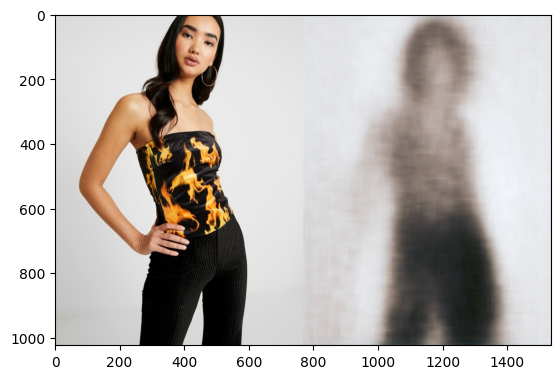

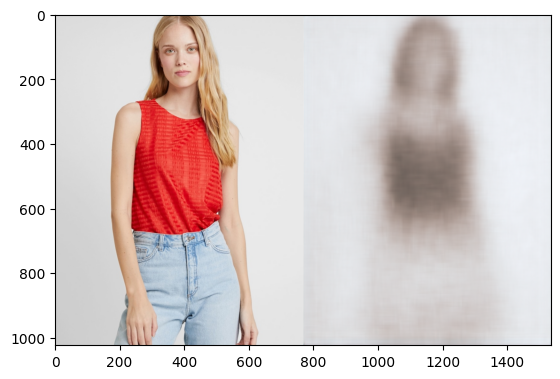

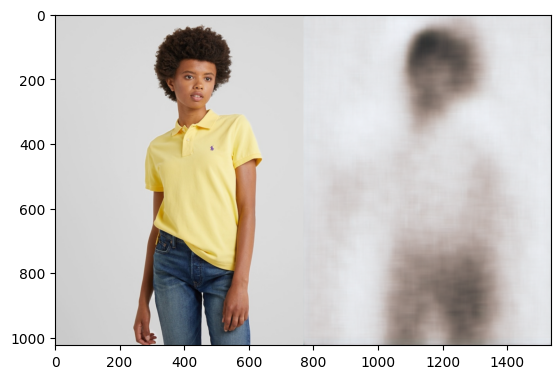

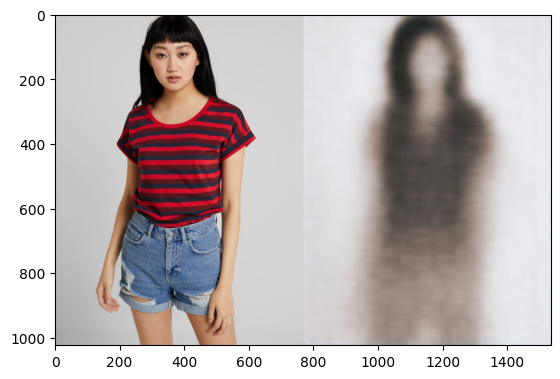

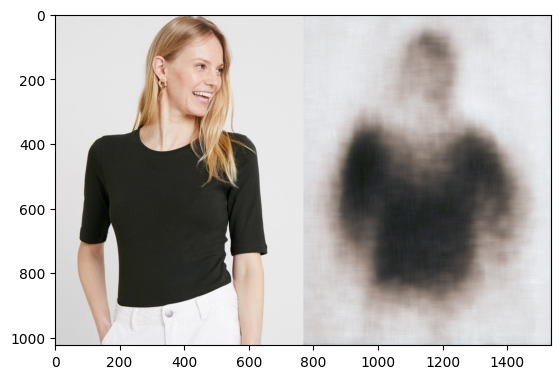

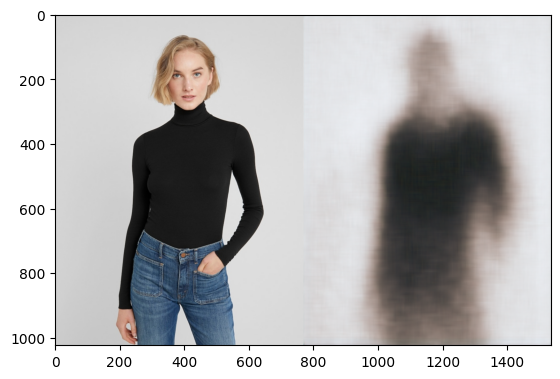

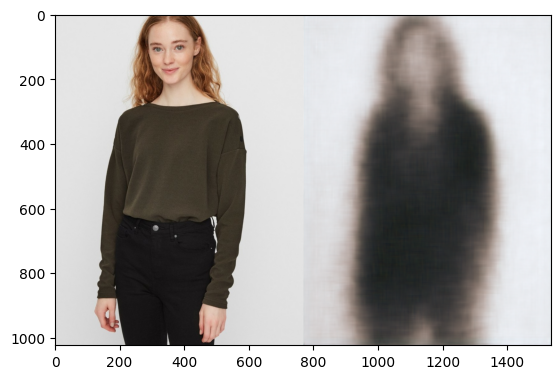

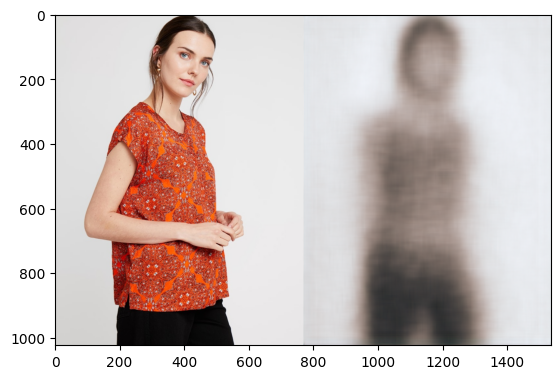

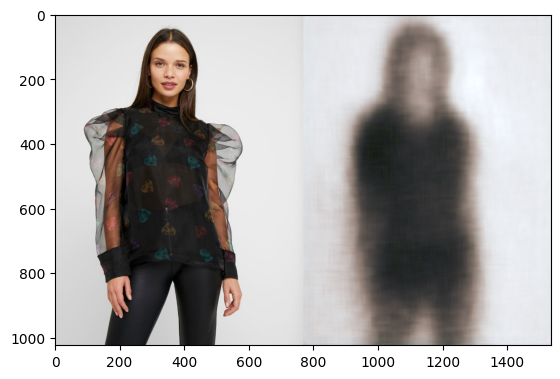

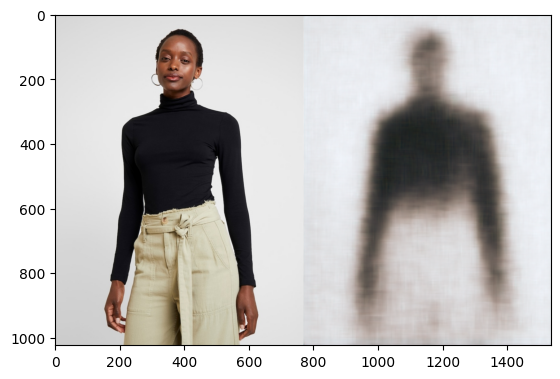

In [102]:
# Training
for epoch in range(num_epochs):
    vae.train()
    for i in tqdm.tqdm(range(len(train_images))):
        image = train_images[i].unsqueeze(0).to(device)
        y,mu,logvar = vae(image)
        loss = (y-image).norm() + 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"epoch : {epoch} ,loss: {loss.item()}")


    # Testing at the end of training
    loss_val = 0
    reconstructed_images = []

    with torch.no_grad():
        vae.eval()
        for j in range(len(test_images)):
            images_val = test_images[j].unsqueeze(0).to(device)
            result_val = vae(images_val)
            y_val, mu_val, logvar_val = result_val
            l = (y_val - images_val).norm() + 0.5 * torch.sum(logvar_val.exp() + mu_val.pow(2) - 1 - logvar_val)
            loss_val += l

            # # Append the reconstructed images for visualization
            if j < 10:
                image_shape = images_val.shape
                concat = PIL.Image.new('RGB', (image_shape[-1]*2, image_shape[-2]))
                concat.paste(utils.tensor_to_image(images_val.data), (0, 0))
                concat.paste(utils.tensor_to_image(y_val.data), (image_shape[-1], 0))
                reconstructed_images.append(concat)

    images = [PIL.Image.fromarray(np.array(image)) for image in reconstructed_images]
    for image in images:
        plt.imshow(image)
        plt.show()



